# Inicialização

In [1]:
import shapely
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gtfs_kit as gk
import pandas as pd
import swifter
import seaborn as sns

In [3]:
from pathlib import Path

path = Path("./gtfs_rio-de-janeiro.zip")

feed = gk.read_feed(path, dist_units='km')

feed.validate()

,type,message,table,rows
3,error,Invalid route_type; maybe has extra space char...,routes,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
0,warning,Unrecognized column agency_id,fare_attributes,[]
1,warning,Unrecognized column agency_id,fare_rules,[]
2,warning,Unrecognized column feed_contact_email,feed_info,[]
4,warning,Unrecognized column platform_code,stops,[]


# Parâmetros

In [4]:
route = '309'
position_parquet_file = './309_2023.parquet'

# Preparação de dados da rota

In [5]:
route_id = feed.routes[feed.routes['route_short_name'] == route]['route_id'].iloc[0]
route_id

'O0309AAA0A'

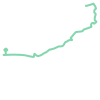

In [6]:
from shapely import LineString, Point

route_geometries = feed.geometrize_routes([route_id], split_directions=True)['geometry']
forwards_geometry: LineString = route_geometries[0]
backwards_geometry: LineString = route_geometries[1]

forwards_geometry

In [7]:
forward_trip = feed.trips[(feed.trips['route_id'] == route_id) & (feed.trips['direction_id'] == 0)].iloc[0]['trip_id']
reverse_trip = feed.trips[(feed.trips['route_id'] == route_id) & (feed.trips['direction_id'] == 1)].iloc[0]['trip_id']
forward_trip, reverse_trip

('8aedc2fc-2ed9-4399-a60d-54501838a81e',
 '8ed81257-ede9-4520-92c8-9d4e77ec6bc6')

In [109]:
forward_trip_stops = feed.stop_times[feed.stop_times['trip_id'] == forward_trip]
backward_trip_stops = feed.stop_times[feed.stop_times['trip_id'] == reverse_trip]

forward_trip_stops['sentido'] = 'I'
backward_trip_stops['sentido'] = 'V'

backward_trip_stops.shape_dist_traveled += forward_trip_stops.shape_dist_traveled.iloc[-1]
backward_trip_stops.stop_sequence += forward_trip_stops.stop_sequence.iloc[-1]

stop_list = pd.concat([forward_trip_stops, backward_trip_stops.iloc[1:]])[['stop_id', 'shape_dist_traveled', 'stop_sequence', 'sentido']]
stop_list['relative_position'] = stop_list['shape_dist_traveled'] / stop_list['shape_dist_traveled'].iloc[-1]
stop_list

C:\Users\thlam\AppData\Local\Temp\ipykernel_26096\449222496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_trip_stops['sentido'] = 'I'
C:\Users\thlam\AppData\Local\Temp\ipykernel_26096\449222496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backward_trip_stops['sentido'] = 'V'
C:\Users\thlam\AppData\Local\Temp\ipykernel_26096\449222496.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,stop_id,shape_dist_traveled,stop_sequence,sentido,relative_position
622952,wcdt,0.00,0,I,0.000000
622953,4128O00209C0,2935.40,1,I,0.040796
622954,4128O00035C0,3746.88,2,I,0.052074
622955,4128O00036C0,4178.28,3,I,0.058069
622956,4128O00037C0,4710.90,4,I,0.065471
...,...,...,...,...,...
642557,4128O00121C0,68369.50,137,V,0.950191
642558,4128O00122C0,68793.55,138,V,0.956084
642559,4128O00055C0,69229.90,139,V,0.962148
642560,4128O00056C0,69683.61,140,V,0.968454


In [110]:
stop_geometries = feed.geometrize_stops(stop_list['stop_id'])[['stop_id', 'geometry']]

stop_list = pd.merge(stop_list, stop_geometries, on='stop_id')
stop_list.set_index('stop_sequence', inplace=True)
stop_list.sort_values('relative_position', inplace=True)
stop_list

,stop_id,shape_dist_traveled,sentido,relative_position,geometry
stop_sequence,,,,,
0,wcdt,0.00,I,0.000000,POINT (-43.36520 -23.00147)
1,4128O00209C0,2935.40,I,0.040796,POINT (-43.36633 -23.00904)
2,4128O00035C0,3746.88,I,0.052074,POINT (-43.36793 -23.01099)
3,4128O00036C0,4178.28,I,0.058069,POINT (-43.36461 -23.01085)
4,4128O00037C0,4710.90,I,0.065471,POINT (-43.35939 -23.01065)
...,...,...,...,...,...
137,4128O00121C0,68369.50,V,0.950191,POINT (-43.35994 -23.01039)
138,4128O00122C0,68793.55,V,0.956084,POINT (-43.36371 -23.01049)
139,4128O00055C0,69229.90,V,0.962148,POINT (-43.36601 -23.00861)


# Preparação de dados de ônibus

In [10]:
bus_positions = pd.read_parquet(position_parquet_file)
bus_positions.timestamp_gps = pd.to_datetime(bus_positions.timestamp_gps)
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo
0,2023-09-11 21:38:09,-22.99241,-43.25229,0,27.9,A41163
1,2023-09-11 10:42:11,-22.90465,-43.19259,0,2.8,A41248
2,2023-07-31 09:08:46,-22.99254,-43.25152,0,35.9,A41053
3,2023-07-31 09:37:16,-22.95230,-43.18678,0,13.0,A41053
4,2023-07-31 16:59:46,-22.96065,-43.20704,0,9.6,A41053
...,...,...,...,...,...,...
34383788,2023-02-15 07:29:55,-23.00712,-43.31080,0,18.1,C41430
34383789,2023-02-18 02:57:56,-23.01053,-43.36566,32,19.1,C41430
34383790,2023-04-06 08:17:58,-23.00730,-43.30674,53,18.1,C41430
34383791,2023-04-13 12:04:14,-23.00146,-43.36593,16,12.6,C41430


In [11]:
bus_positions.sort_values('timestamp_gps', inplace=True)
bus_positions.reset_index(drop=True, inplace=True)
bus_positions.drop_duplicates(subset=['id_veiculo', 'timestamp_gps'], inplace=True, keep='last')
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo
0,2023-01-01 00:00:01,-22.87554,-43.24146,0,0.2,C41424
1,2023-01-01 00:00:14,-22.94561,-43.18253,0,29.5,C41265
2,2023-01-01 00:00:26,-23.00025,-43.35741,50,15.9,A41104
3,2023-01-01 00:00:26,-22.87532,-43.24192,0,0.0,A41278
4,2023-01-01 00:00:31,-22.87554,-43.24146,0,0.2,C41424
...,...,...,...,...,...,...
34383788,2023-11-01 23:59:55,-22.90461,-43.19255,0,20.5,C41021
34383789,2023-11-01 23:59:56,-22.90462,-43.19244,0,14.5,A41016
34383790,2023-11-01 23:59:58,-22.90553,-43.18277,26,14.1,A41190
34383791,2023-11-01 23:59:59,-22.99909,-43.24826,43,34.0,A41463


In [107]:
bus_trips = pd.read_parquet("./309_2023_viagens.parquet")
bus_trips.datetime_chegada = pd.to_datetime(bus_trips.datetime_chegada)
bus_trips.datetime_partida = pd.to_datetime(bus_trips.datetime_partida)
bus_trips.sort_values(by='datetime_partida', inplace=True)
bus_trips.reset_index(drop=True, inplace=True)
bus_trips

,datetime_partida,datetime_chegada,id_veiculo,sentido,tempo_viagem
0,2023-01-01 05:00:22,2023-01-01 05:55:22,C41054,I,56
1,2023-01-01 05:42:45,2023-01-01 06:47:15,C41215,I,66
2,2023-01-01 06:46:39,2023-01-01 07:57:09,A41282,I,72
3,2023-01-01 07:04:50,2023-01-01 08:10:50,C41010,I,67
4,2023-01-01 07:21:04,2023-01-01 08:22:34,C41021,I,62
...,...,...,...,...,...
63387,2023-07-30 22:37:12,2023-07-30 23:39:42,C41385,I,63
63388,2023-07-30 22:55:23,2023-07-30 23:54:53,A41016,I,60
63389,2023-07-30 23:11:43,2023-07-31 00:19:13,A41457,I,69
63390,2023-07-30 23:25:41,2023-07-31 00:26:41,A41125,I,62


In [13]:
merged_df = pd.merge_asof(bus_positions, bus_trips, by='id_veiculo', left_on='timestamp_gps', right_on='datetime_partida', direction='backward')
merged_df = merged_df[(merged_df['timestamp_gps'] >= merged_df['datetime_partida']) &
                      (merged_df['timestamp_gps'] <= merged_df['datetime_chegada'])]
bus_positions = merged_df.sort_values(['id_veiculo', 'timestamp_gps'])
bus_positions.reset_index(drop=True, inplace=True)
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,datetime_partida,datetime_chegada,sentido,tempo_viagem
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0
...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0


# Cálculo de localização

## Localização relativa do ônibus na rota

In [17]:
def to_point(row):
    return Point(row['longitude'], row['latitude'])
bus_positions['geometry'] = bus_positions[['latitude', 'longitude']].swifter.apply(to_point, axis=1)
bus_positions

Pandas Apply:   0%|          | 0/10306447 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
total_geometry_length = forwards_geometry.length + backwards_geometry.length

forwards_bus_positions = bus_positions[bus_positions['sentido'] == 'I']
forwards_bus_projections = forwards_geometry.project(forwards_bus_positions['geometry'])
forwards_bus_interpolations = forwards_geometry.interpolate(forwards_bus_projections)
forwards_bus_final_projection = forwards_geometry.project(forwards_bus_interpolations)
forwards_bus_roundtrip_locations = forwards_bus_final_projection / total_geometry_length
forwards_bus_locations = forwards_bus_final_projection / forwards_geometry.length

backwards_bus_positions = bus_positions[bus_positions['sentido'] == 'V']
backwards_bus_projections = backwards_geometry.project(backwards_bus_positions['geometry'])
backwards_bus_interpolations = backwards_geometry.interpolate(backwards_bus_projections)
backwards_bus_final_projection = backwards_geometry.project(backwards_bus_interpolations)
backwards_bus_roundtrip_locations = (backwards_bus_final_projection + forwards_geometry.length) / total_geometry_length
backwards_bus_locations = backwards_bus_final_projection / backwards_geometry.length

bus_positions['relative_roundtrip_distance'] = pd.concat([forwards_bus_roundtrip_locations, backwards_bus_roundtrip_locations])
bus_positions['relative_distance'] = pd.concat([forwards_bus_locations, backwards_bus_locations])
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688


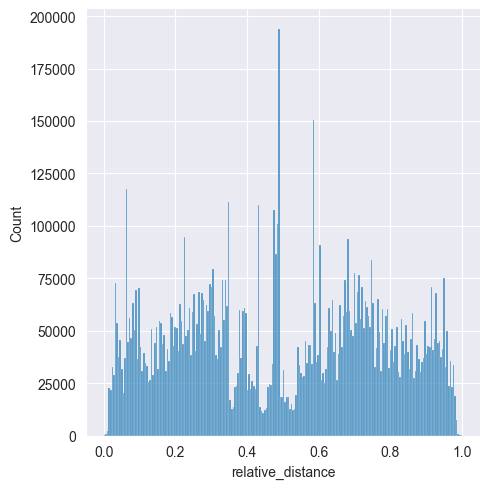

In [22]:
sns.displot(bus_positions['relative_distance'])

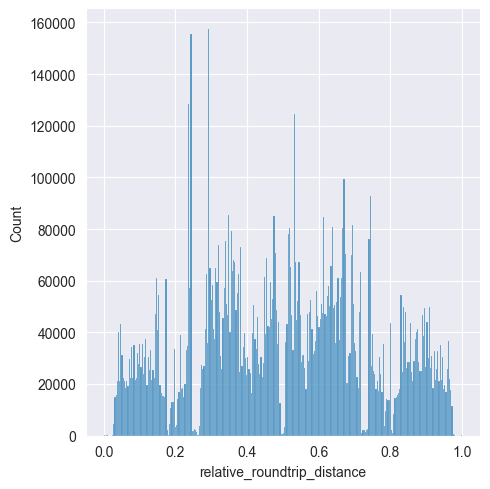

In [23]:
sns.displot(bus_positions['relative_roundtrip_distance'])

## Parada onde o ônibus está

In [24]:
bus_positions['next_stop_index'] = stop_list['relative_position'].searchsorted(bus_positions['relative_roundtrip_distance'], side='left')
bus_positions['previous_stop_index'] = bus_positions['next_stop_index'] - 1
bus_positions.loc[bus_positions['previous_stop_index'] == -1, 'previous_stop_index'] = 0
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67


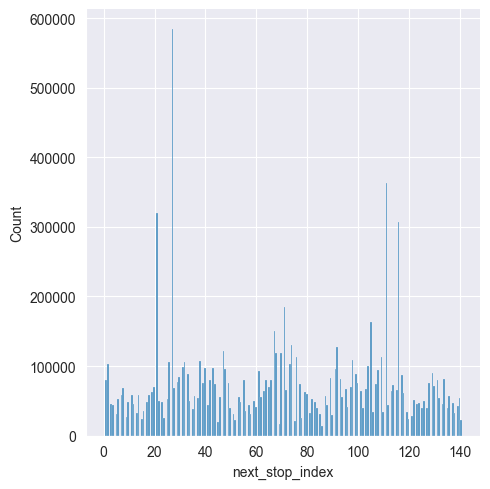

In [25]:
sns.displot(bus_positions['next_stop_index'])

## Distância do ônibus até a rota

In [26]:
forwards_bus_distances = forwards_geometry.distance(forwards_bus_positions['geometry'])
backwards_bus_distances = backwards_geometry.distance(backwards_bus_positions['geometry'])

bus_positions['distance_from_route'] = pd.concat([forwards_bus_distances, backwards_bus_distances])
bus_positions

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038


# Análise

## Validade dos dados - os ônibus estão seguindo a rota?

<Axes: ylabel='distance_from_route'>

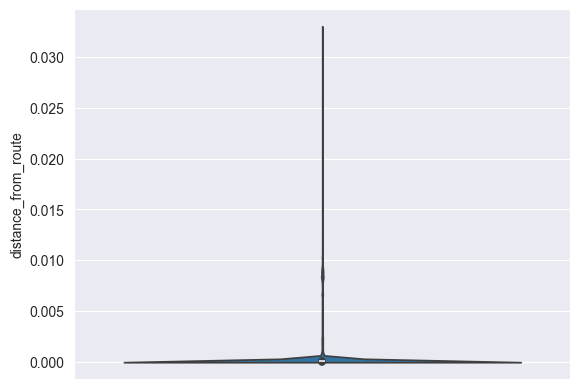

In [27]:
sns.violinplot(bus_positions['distance_from_route'])

## Os ônibus são menos bem servidos em hora de pico?

In [28]:
hourly_periods = [hour for hour in range(24)]

bus_trips_periods = bus_trips[['datetime_partida', 'datetime_chegada']].swifter.apply(lambda x: [hour for hour in hourly_periods if x['datetime_partida'].hour <= hour <= x['datetime_chegada'].hour], axis=1)
bus_trips_periods

Pandas Apply:   0%|          | 0/63392 [00:00<?, ?it/s]

0             [5]
1          [5, 6]
2          [6, 7]
3          [7, 8]
4          [7, 8]
           ...   
63387    [22, 23]
63388    [22, 23]
63389          []
63390          []
63391          []
Length: 63392, dtype: object

In [29]:
bus_trip_count_by_period = bus_trips_periods.explode().value_counts()

<Axes: ylabel='count'>

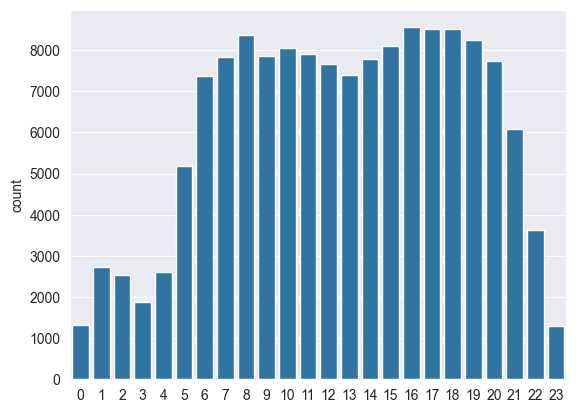

In [30]:
sns.barplot(bus_trip_count_by_period)

In [31]:
bus_positions['timestamp_hour'] = bus_positions.timestamp_gps.dt.hour

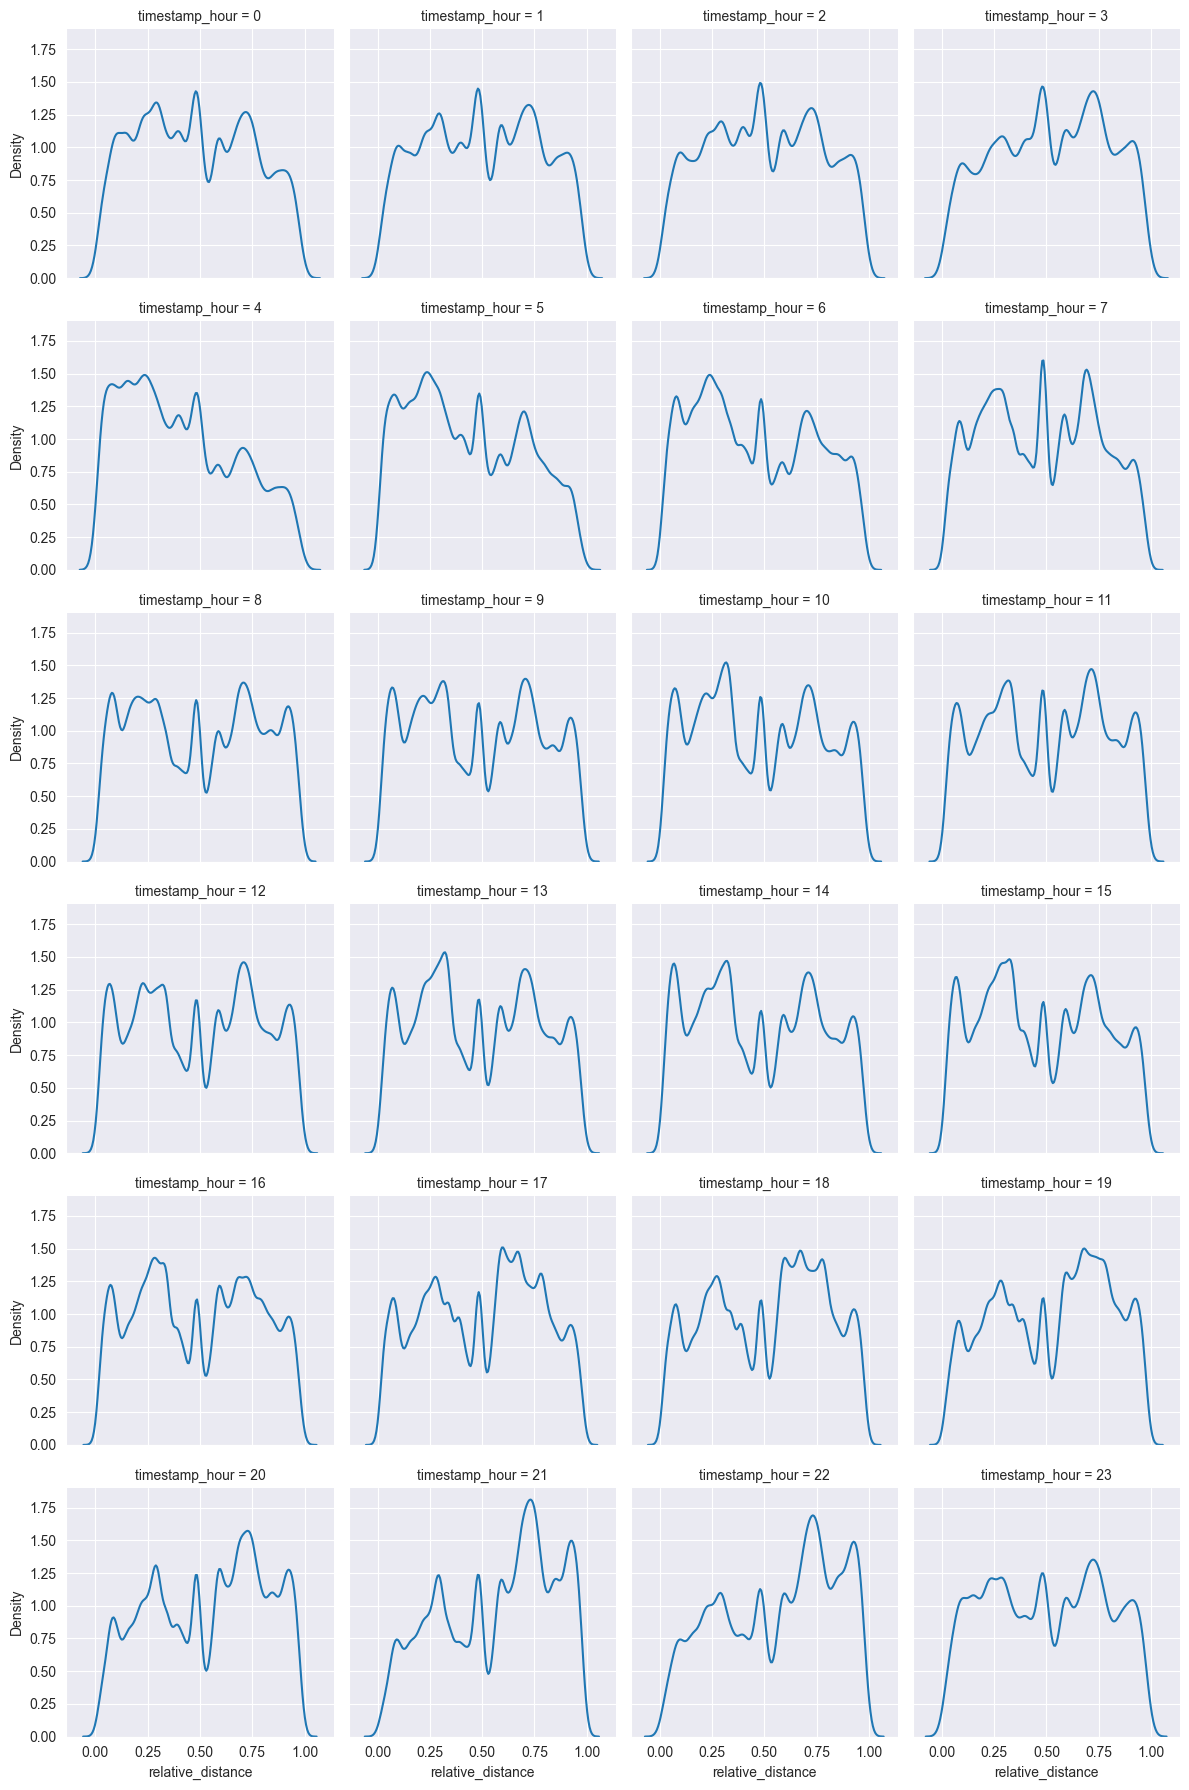

In [32]:
sns.FacetGrid(bus_positions, col='timestamp_hour', col_wrap=4).map(sns.kdeplot, 'relative_distance')

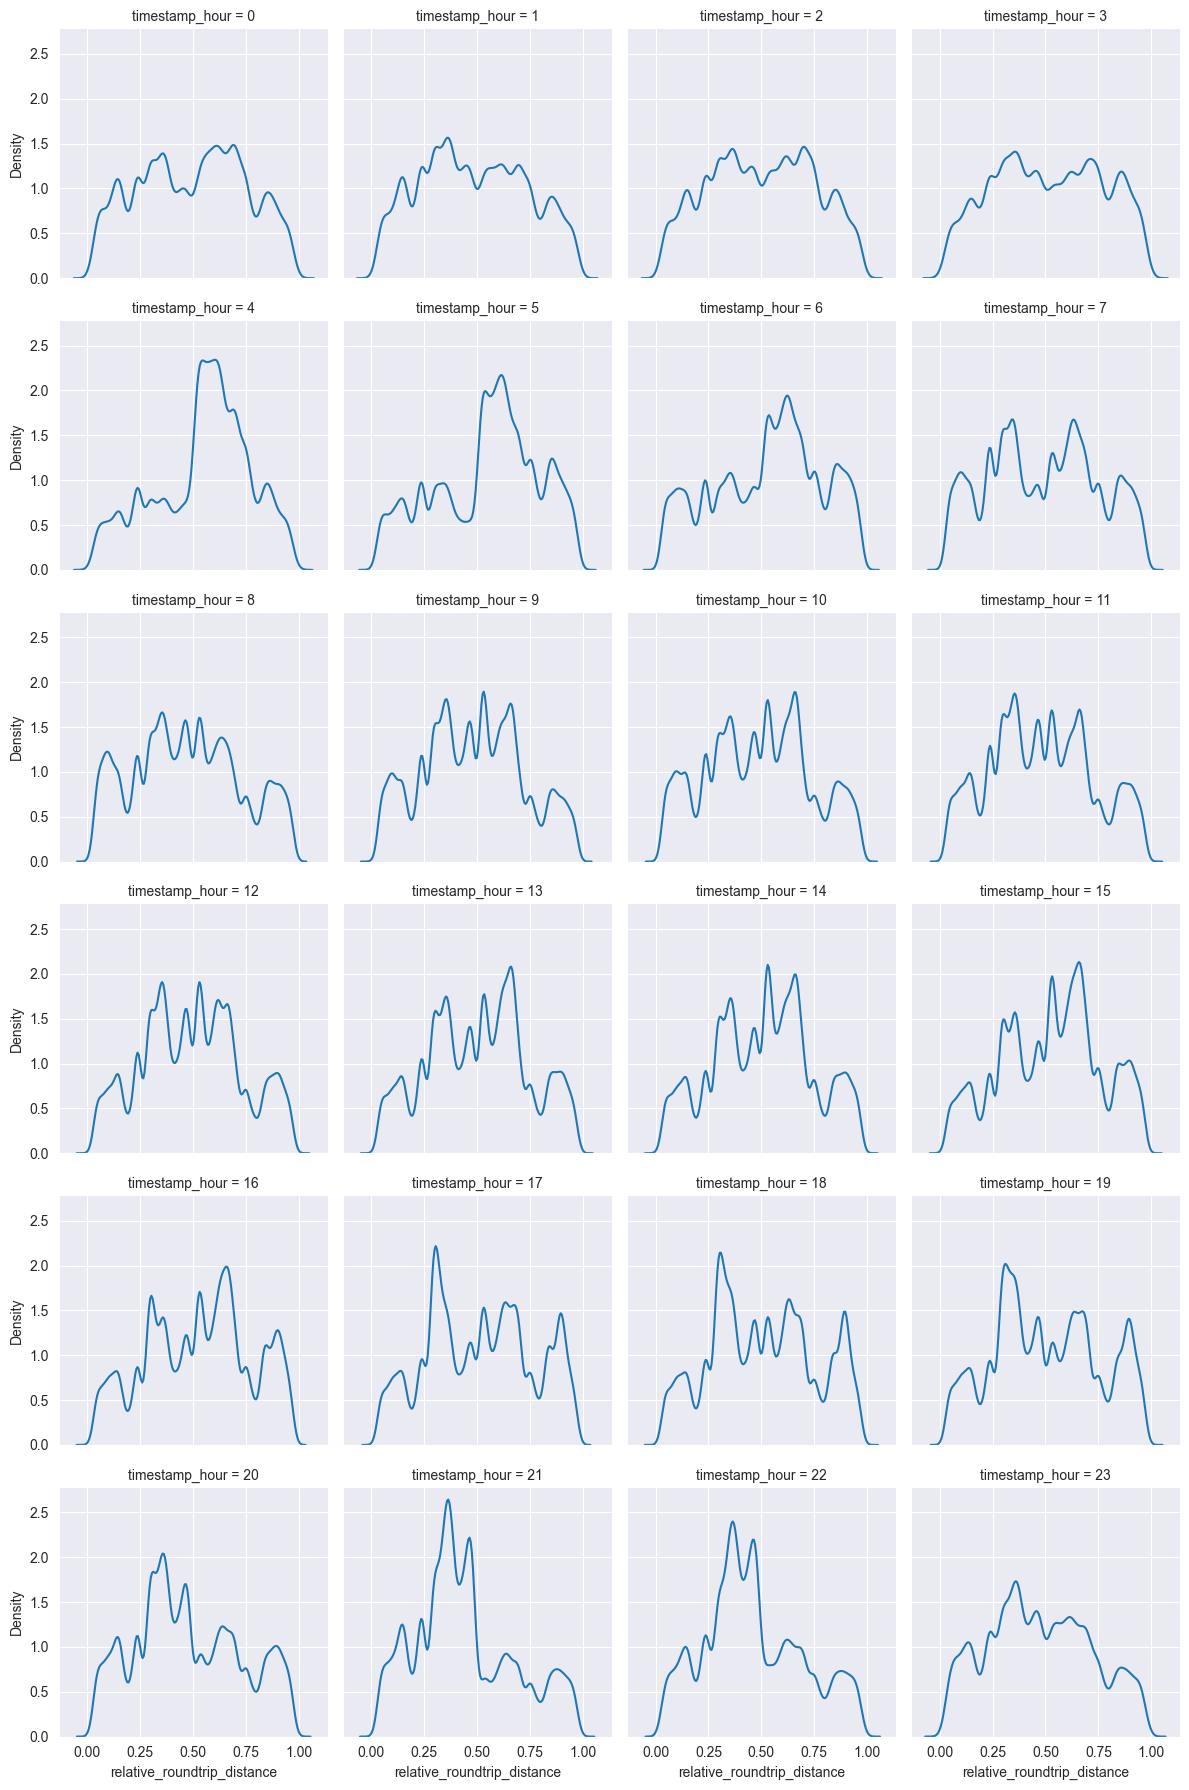

In [33]:
sns.FacetGrid(bus_positions, col='timestamp_hour', col_wrap=4).map(sns.kdeplot, 'relative_roundtrip_distance')

In [34]:
bus_positions['stop_distance'] = bus_positions.swifter.apply(lambda x: stop_list.loc[x['next_stop_index'], 'shape_dist_traveled'] - stop_list.loc[x['previous_stop_index'], 'shape_dist_traveled'], axis=1)
bus_positions  

Pandas Apply:   0%|          | 0/10306447 [00:00<?, ?it/s]

,timestamp_gps,latitude,longitude,velocidade_instantanea,velocidade_estimada_10_min,id_veiculo,datetime_partida,datetime_chegada,sentido,tempo_viagem,geometry,relative_roundtrip_distance,relative_distance,next_stop_index,previous_stop_index,distance_from_route,timestamp_hour,stop_distance
0,2023-01-21 15:30:23,-22.90116,-43.18919,21,8.3,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18919 -22.90116),0.508194,0.017065,70,69,0.000042,15,1137.20
1,2023-01-21 15:30:53,-22.90051,-43.18815,14,9.0,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18815 -22.90051),0.509991,0.020657,70,69,0.000053,15,1137.20
2,2023-01-21 15:31:23,-22.90031,-43.18695,31,9.6,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18695 -22.90031),0.512295,0.025263,70,69,0.000072,15,1137.20
3,2023-01-21 15:31:53,-22.90179,-43.18496,10,11.4,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18496 -22.90179),0.515924,0.032515,71,70,0.000014,15,534.65
4,2023-01-21 15:32:23,-22.90200,-43.18444,20,11.1,A41002,2023-01-21 15:30:23,2023-01-21 16:48:53,V,79.0,POINT (-43.18444 -22.902),0.516765,0.034197,71,70,0.000021,15,534.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306442,2023-07-25 21:07:48,-22.90116,-43.17926,26,27.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.17926 -22.90116),0.476072,0.952802,67,66,0.000040,21,487.88
10306443,2023-07-25 21:08:18,-22.90138,-43.18009,21,26.8,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18009 -22.90138),0.477393,0.955445,67,66,0.000137,21,487.88
10306444,2023-07-25 21:08:48,-22.90224,-43.18263,38,28.7,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.18263 -22.90224),0.481319,0.963303,68,67,0.000101,21,640.61
10306445,2023-07-25 21:09:18,-22.90330,-43.18600,46,28.4,C41430,2023-07-25 20:04:29,2023-07-25 21:10:48,I,67.0,POINT (-43.186 -22.9033),0.486508,0.973688,68,67,0.000038,21,640.61


In [35]:
average_speed_by_hour_and_segment = bus_positions.groupby(['timestamp_hour', 'next_stop_index']).agg({
    'velocidade_instantanea': 'mean',
    'stop_distance': 'first'
}).reset_index()
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance
0,0,1,49.875878,2935.40
1,0,2,37.432267,811.48
2,0,3,33.026226,431.40
3,0,4,49.444295,532.62
4,0,5,53.374741,370.84
...,...,...,...,...
3384,23,137,33.509284,455.99
3385,23,138,48.104925,424.05
3386,23,139,47.598039,436.35
3387,23,140,40.671318,453.71


In [36]:
average_speed_by_hour_and_segment['time_to_serve'] = average_speed_by_hour_and_segment['stop_distance'] / (average_speed_by_hour_and_segment['velocidade_instantanea'] / 3.6)
average_speed_by_hour_and_segment

,timestamp_hour,next_stop_index,velocidade_instantanea,stop_distance,time_to_serve
0,0,1,49.875878,2935.40,211.874765
1,0,2,37.432267,811.48,78.043043
2,0,3,33.026226,431.40,47.024447
3,0,4,49.444295,532.62,38.779641
4,0,5,53.374741,370.84,25.012281
...,...,...,...,...,...
3384,23,137,33.509284,455.99,48.988334
3385,23,138,48.104925,424.05,31.734381
3386,23,139,47.598039,436.35,33.002620
3387,23,140,40.671318,453.71,40.159899


In [37]:
stop_serve_time = average_speed_by_hour_and_segment.set_index(["timestamp_hour", "next_stop_index"])['time_to_serve']
stop_serve_time.sort_index(inplace=True)
stop_serve_time

timestamp_hour  next_stop_index
0               1                  211.874765
                2                   78.043043
                3                   47.024447
                4                   38.779641
                5                   25.012281
                                      ...    
23              137                 48.988334
                138                 31.734381
                139                 33.002620
                140                 40.159899
                141                154.430402
Name: time_to_serve, Length: 3389, dtype: float64

In [38]:
days = bus_trips.datetime_chegada.dt.day_of_year.unique()
days

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [115]:
from tqdm import tqdm

forward_stops = stop_list[stop_list['sentido'] == 'I'].index

day_visits = {}
for day in tqdm(days, total=len(days)):
    trips = bus_trips[(bus_trips.datetime_chegada.dt.day_of_year == day) & (bus_trips.sentido == 'I')]
    stop_visit_times = {stop: [] for stop in forward_stops}
    for index, trip in trips.iterrows():
        hour = trip['datetime_partida'].hour
        current_time = trip['datetime_partida']
        for stop in forward_stops:
            stop_visit_times[stop].append(current_time)
            current_time += (stop_serve_time[hour, stop] if stop > 0 else 0) * pd.Timedelta(seconds=1)
    day_visits[day] = stop_visit_times

100%|██████████| 212/212 [00:45<00:00,  4.68it/s]


In [159]:
day_dataframe = pd.DataFrame.from_dict(day_visits, orient='index')
day_dataframe.reset_index(inplace=True, names='day_of_year')
day_dataframe = day_dataframe.melt(
    id_vars=['day_of_year'],
    var_name='stop number',
    value_name='visit_times'
)
day_dataframe = day_dataframe.explode('visit_times', ignore_index=True)
day_dataframe.sort_values(['day_of_year', 'stop number', 'visit_times'], inplace=True)
day_dataframe

,day_of_year,stop number,visit_times
0,1,0,2023-01-01 05:00:22.000000000
1,1,0,2023-01-01 05:42:45.000000000
2,1,0,2023-01-01 06:46:39.000000000
3,1,0,2023-01-01 07:04:50.000000000
4,1,0,2023-01-01 07:21:04.000000000
...,...,...,...
2168111,212,67,2023-07-31 00:32:47.181301778
2199994,212,68,2023-07-31 00:20:34.690961861
2199995,212,68,2023-07-31 00:34:32.690961861
2231878,212,69,2023-07-31 00:21:50.228696309


In [160]:
day_dataframe = day_dataframe[(7 <= day_dataframe['visit_times'].dt.hour) & (day_dataframe['visit_times'].dt.hour <= 21)]

In [161]:
shifted = day_dataframe.groupby(['day_of_year', 'stop number'])['visit_times'].shift(1)
day_dataframe['time_since_last_visit'] = day_dataframe['visit_times'] - shifted
day_dataframe

C:\Users\thlam\AppData\Local\Temp\ipykernel_26096\3502751507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['time_since_last_visit'] = day_dataframe['visit_times'] - shifted


,day_of_year,stop number,visit_times,time_since_last_visit
3,1,0,2023-01-01 07:04:50.000000000,NaT
4,1,0,2023-01-01 07:21:04.000000000,0 days 00:16:14
5,1,0,2023-01-01 08:02:25.000000000,0 days 00:41:21
6,1,0,2023-01-01 09:05:06.000000000,0 days 01:02:41
7,1,0,2023-01-01 09:11:43.000000000,0 days 00:06:37
...,...,...,...,...
2231865,211,69,2023-07-30 21:14:15.521886076,0 days 00:16:24
2231866,211,69,2023-07-30 21:24:11.521886076,0 days 00:09:56
2231868,211,69,2023-07-30 21:36:55.448910591,0 days 00:12:43.927024515
2231867,211,69,2023-07-30 21:37:59.521886076,0 days 00:01:04.072975485


In [162]:
day_dataframe['wait time (s)'] = day_dataframe['time_since_last_visit'].dt.seconds
day_dataframe['wait difference from avg (s)'] = day_dataframe['wait time (s)'] - day_dataframe['wait time (s)'].mean()
day_dataframe

C:\Users\thlam\AppData\Local\Temp\ipykernel_26096\4216892198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['wait time (s)'] = day_dataframe['time_since_last_visit'].dt.seconds
C:\Users\thlam\AppData\Local\Temp\ipykernel_26096\4216892198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['wait difference from avg (s)'] = day_dataframe['wait time (s)'] - day_dataframe['wait time (s)'].mean()


,day_of_year,stop number,visit_times,time_since_last_visit,wait time (s),wait difference from avg (s)
3,1,0,2023-01-01 07:04:50.000000000,NaT,NaN,NaN
4,1,0,2023-01-01 07:21:04.000000000,0 days 00:16:14,974.0,519.040438
5,1,0,2023-01-01 08:02:25.000000000,0 days 00:41:21,2481.0,2026.040438
6,1,0,2023-01-01 09:05:06.000000000,0 days 01:02:41,3761.0,3306.040438
7,1,0,2023-01-01 09:11:43.000000000,0 days 00:06:37,397.0,-57.959562
...,...,...,...,...,...,...
2231865,211,69,2023-07-30 21:14:15.521886076,0 days 00:16:24,984.0,529.040438
2231866,211,69,2023-07-30 21:24:11.521886076,0 days 00:09:56,596.0,141.040438
2231868,211,69,2023-07-30 21:36:55.448910591,0 days 00:12:43.927024515,763.0,308.040438
2231867,211,69,2023-07-30 21:37:59.521886076,0 days 00:01:04.072975485,64.0,-390.959562


In [163]:
day_dataframe['hour'] = day_dataframe['visit_times'].dt.hour
average_hourly_wait = day_dataframe.groupby(['stop number', 'hour']).agg({'wait time (s)': 'mean', 'wait difference from avg (s)': 'mean'})
average_hourly_wait.reset_index(inplace=True)
average_hourly_wait

C:\Users\thlam\AppData\Local\Temp\ipykernel_26096\2370127235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_dataframe['hour'] = day_dataframe['visit_times'].dt.hour


,stop number,hour,wait time (s),wait difference from avg (s)
0,0,7,423.636865,-31.322697
1,0,8,404.047824,-50.911738
2,0,9,491.268714,36.309152
3,0,10,429.396571,-25.562990
4,0,11,443.986301,-10.973260
...,...,...,...,...
1045,69,17,560.023827,105.064265
1046,69,18,502.220441,47.260879
1047,69,19,470.047073,15.087511
1048,69,20,388.874356,-66.085205


In [164]:
average_wait_time_by_hour = average_hourly_wait.groupby('hour')['wait time (s)'].mean().reset_index()
average_wait_time_by_hour['wait difference from avg (s)'] = average_wait_time_by_hour['wait time (s)'] - average_wait_time_by_hour['wait time (s)'].mean()
average_wait_time_by_hour

,hour,wait time (s),wait difference from avg (s)
0,7,399.503453,-63.210416
1,8,450.188258,-12.525611
2,9,441.243859,-21.470011
3,10,459.028675,-3.685194
4,11,433.688739,-29.025130
5,12,461.680105,-1.033764
6,13,520.966368,58.252499
7,14,531.620149,68.906279
8,15,534.009590,71.295720
9,16,538.655101,75.941232


<Axes: xlabel='hour', ylabel='wait time (s)'>

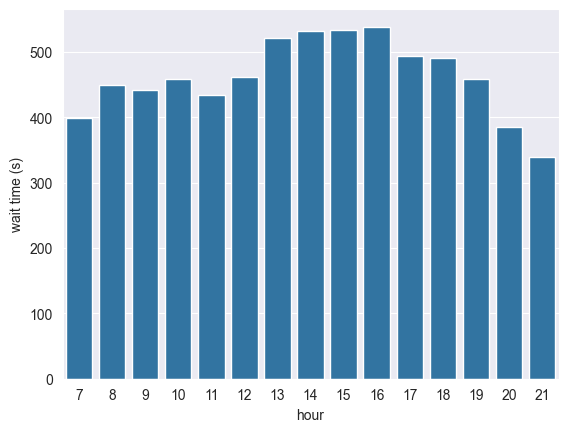

In [165]:
sns.barplot(average_wait_time_by_hour, x='hour', y='wait time (s)')

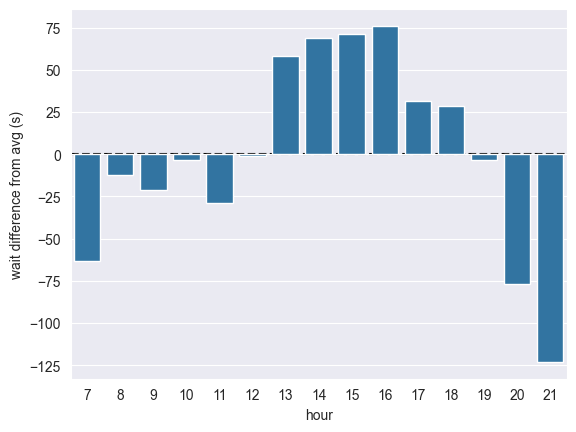

In [205]:
g = sns.barplot(average_wait_time_by_hour, x='hour', y='wait difference from avg (s)')
line = g.axhline(y=0, color='black', linestyle='--', zorder=-1)

In [179]:
grouped_df = day_dataframe.groupby(['day_of_year', 'hour', 'stop number']).agg({'wait time (s)': 'mean', 'wait difference from avg (s)': 'mean'}).reset_index()

grouped_df

,day_of_year,hour,stop number,wait time (s),wait difference from avg (s)
0,1,7,0,974.000000,519.040438
1,1,7,1,974.000000,519.040438
2,1,7,2,974.000000,519.040438
3,1,7,3,974.000000,519.040438
4,1,7,4,974.000000,519.040438
...,...,...,...,...,...
220381,211,21,65,598.857143,143.897581
220382,211,21,66,588.600000,133.640438
220383,211,21,67,585.000000,130.040438
220384,211,21,68,579.800000,124.840438


In [183]:
grouped_df_withou_outliers = grouped_df[grouped_df['wait difference from avg (s)'].abs() < 300]

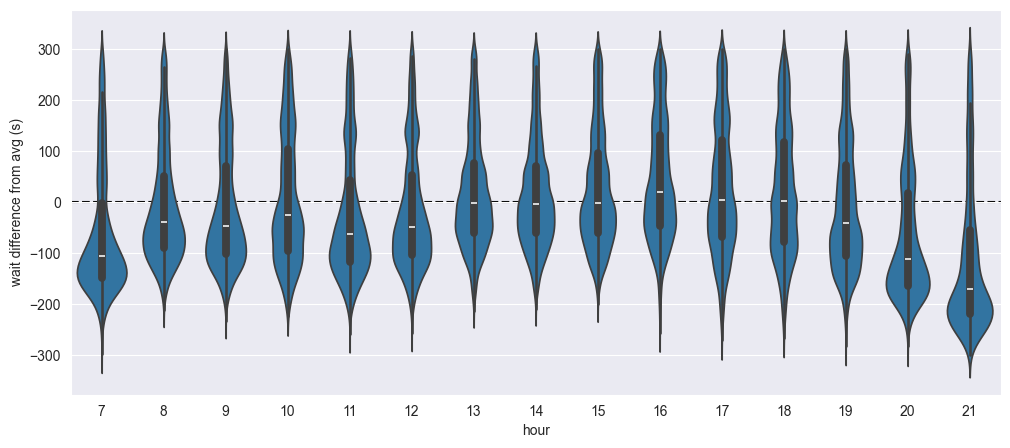

In [204]:
g = sns.violinplot(grouped_df_withou_outliers, x='hour', y='wait difference from avg (s)')
g.figure.set_size_inches(12, 5)
line = g.axhline(y=0, color='black', linestyle='--', zorder=-1)